
# Δ‑Wave Explorer (v3) — Slopes, Second Differences & Density

**One‑click Colab** notebook that:

1. Computes Δ(n) = |(i/2ⁿ)² − C| for φ, π, α, √3 / π, and harmonic ratios 1/H₂ … 1/H₄ (n = 1…45).
2. Visualises  
   * **log₁₀ Δ vs n** (decay slope)  
   * **Second finite difference** of log₁₀ Δ (wave detector)  
   * **Hit‑density vs ε** (ε ∈ 10⁻²…10⁻¹⁵)
3. Calculates **median log₁₀ Δ for n ≥ 20** — a slope‑neutral tightness metric.
4. Saves two CSVs: all Δ points and the median summary.

Open → **Runtime ▸ Run all** → results appear in < 10 s on a free Colab CPU.


In [1]:

# ⬇️ Imports & parameters
import mpmath as mp, numpy as np, pandas as pd, matplotlib.pyplot as plt, time
mp.mp.dps = 40  # 128‑bit precision

MAX_BITS = 45

# Core constants
consts = [
    ('phi', (1 + mp.sqrt(5)) / 2),
    ('pi', mp.pi),
    ('alpha', mp.mpf(1) / mp.mpf('137.035999')),
    ('sqrt3_pi', mp.sqrt(3) / mp.pi),
]
def H(n): return mp.nsum(lambda k: 1/mp.mpf(k), [1, n])
consts += [(f'harm_{k}', 1 / H(k)) for k in range(2, 5)]

print('Constants:', ', '.join(name for name,_ in consts))


Constants: phi, pi, alpha, sqrt3_pi, harm_2, harm_3, harm_4


In [2]:

# ⚙️ Compute Δ curves
def delta_curve(C, max_bits=MAX_BITS):
    sqrtC = mp.sqrt(C)
    ns, deltas = [], []
    for n in range(1, max_bits + 1):
        denom = mp.mpf(1 << n)
        i = mp.nint(sqrtC * denom)
        val = (i / denom) ** 2
        ns.append(n)
        deltas.append(float(abs(val - C)))
    return np.array(ns, dtype=int), np.array(deltas, dtype=float)

curves = {name: delta_curve(C) for name, C in consts}
print("Δ curves computed for", len(curves), "constants.")


Δ curves computed for 7 constants.


In [3]:

# 📊 Median log10 Δ for n ≥ 20
summary = []
for name, (n, d) in curves.items():
    mask = n >= 20
    summary.append((name, np.median(np.log10(d[mask]))))
median_df = pd.DataFrame(summary, columns=['constant', 'median_log10Δ_n≥20']).sort_values('median_log10Δ_n≥20')
display(median_df)


,constant,median_log10Δ_n≥20
2,alpha,-11.255932
5,harm_3,-10.949287
3,sqrt3_pi,-10.346128
6,harm_4,-10.203151
0,phi,-10.137798
4,harm_2,-10.090990
1,pi,-9.697622


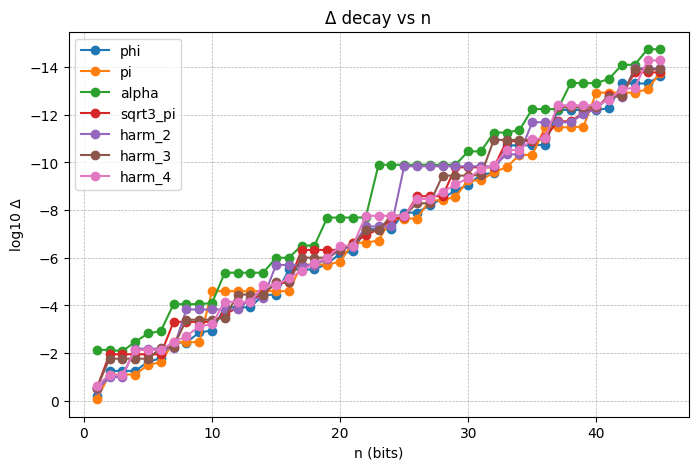

In [4]:

# Plot log10 Δ vs n
plt.figure(figsize=(8,5))
for name, (n, d) in curves.items():
    plt.plot(n, np.log10(d), marker='o', label=name)
plt.gca().invert_yaxis()
plt.xlabel('n (bits)'); plt.ylabel('log10 Δ'); plt.title('Δ decay vs n')
plt.grid(True, ls='--', lw=0.5); plt.legend()
plt.show()


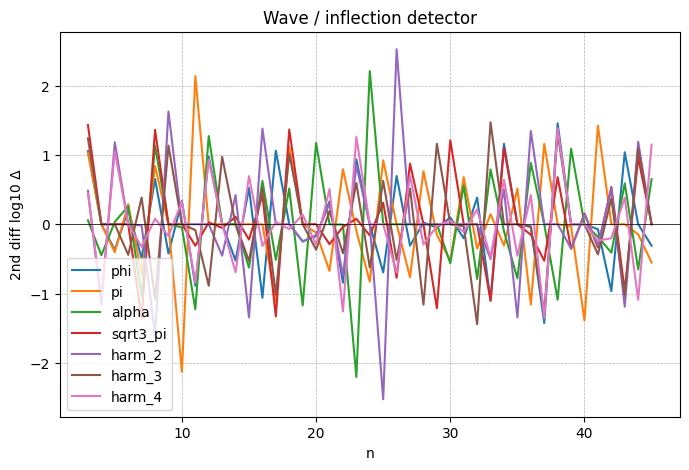

In [5]:

# Second finite difference of log10 Δ
plt.figure(figsize=(8,5))
for name, (n, d) in curves.items():
    l = np.log10(d)
    second = np.diff(l, 2)
    plt.plot(n[2:], second, label=name)
plt.axhline(0, color='k', lw=0.5)
plt.xlabel('n'); plt.ylabel('2nd diff log10 Δ')
plt.title('Wave / inflection detector')
plt.grid(True, ls='--', lw=0.5); plt.legend()
plt.show()


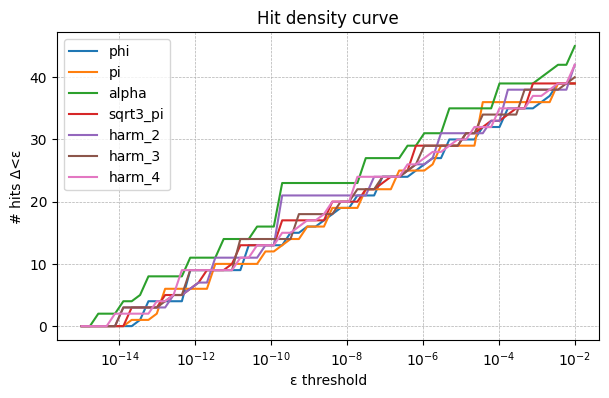

In [6]:

# Hit-density vs ε
eps_range = np.logspace(-2, -15, 60)
plt.figure(figsize=(7,4))
for name, (n, d) in curves.items():
    counts = [(d < eps).sum() for eps in eps_range]
    plt.plot(eps_range, counts, label=name)
plt.xscale('log'); plt.xlabel('ε threshold'); plt.ylabel('# hits Δ<ε')
plt.title('Hit density curve'); plt.grid(True, ls='--', lw=0.5); plt.legend()
plt.show()


In [7]:

# 💾 Export CSVs
rows = []
for name, (n, d) in curves.items():
    for nn, dd in zip(n, d):
        rows.append((name, nn, dd))
df = pd.DataFrame(rows, columns=['constant','n','delta'])
ts = time.strftime('%Y%m%d_%H%M%S')
all_csv = f'delta_curves_{ts}.csv'
med_csv = f'median_log_delta_{ts}.csv'
df.to_csv(all_csv, index=False)
median_df.to_csv(med_csv, index=False)
print('Saved CSVs:', all_csv, 'and', med_csv)


Saved CSVs: delta_curves_20250716_121033.csv and median_log_delta_20250716_121033.csv
